<a href="https://colab.research.google.com/github/pedrogaldo/PERFECT-PITCH/blob/IA/pruebas_PP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Imports**

In [ ]:
'''#numpy
import numpy as np #para trabajar con arrays y transformadas

#matplotlib
import matplotlib.pyplot as plt #para graficar diferentes cosas dentro del arhivo de audio

#pandas
import pandas as pd

#IPython
import IPython.display as ipd #para poder reproducir archivos de audio

#librosa
import librosa, librosa.display #para cargar y procesar audio 

#MIDIUtil
#from MidiUtil import MIDIFile #generar archivos MIDI
'''
#music21
from music21.tempo import MetronomeMark 
# from midiutil import MIDIFile
from music21.tempo import MetronomeMark   
from music21.note import Note, Rest
from music21.stream import Stream
from music21 import metadata
from music21 import instrument
from music21 import midi 
from music21.key import Key

In [ ]:
%matplotlib inline
import seaborn
import numpy as np, scipy, IPython.display as ipd, matplotlib.pyplot as plt
import librosa, librosa.display
plt.rcParams['figure.figsize'] = (14, 5)

# **Parametros**

In [ ]:
fs = 44100 #frecuencia de samples
nfft = 2048 #tamaño transofrmada de fourier
hop_length = 512 #cantidad de samples entre "cuadros"
bins = 72 # espacios para guardar frecuencias
binsXoctava = 36
umbral_cqt = -60 #umbral para eliminar sonidos no deseados del cqt
magnitud = 4 
pre_post_max = 6 

# **Cargar audio**

In [ ]:
filename = '/content/audio piano.mp3'
x, sr = librosa.load(filename)
ipd.Audio (x, rate=sr)

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


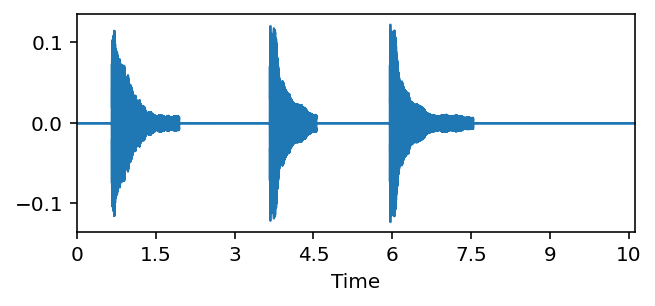

In [ ]:
#forma de onda
plt.figure(figsize=(5,2))
librosa.display.waveplot(x,sr)

# **Transformada**

Descompone el audio en las diferentes frecuencias que suenan en el tiempo

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:1642: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  "amplitude_to_db was called on complex input so phase "


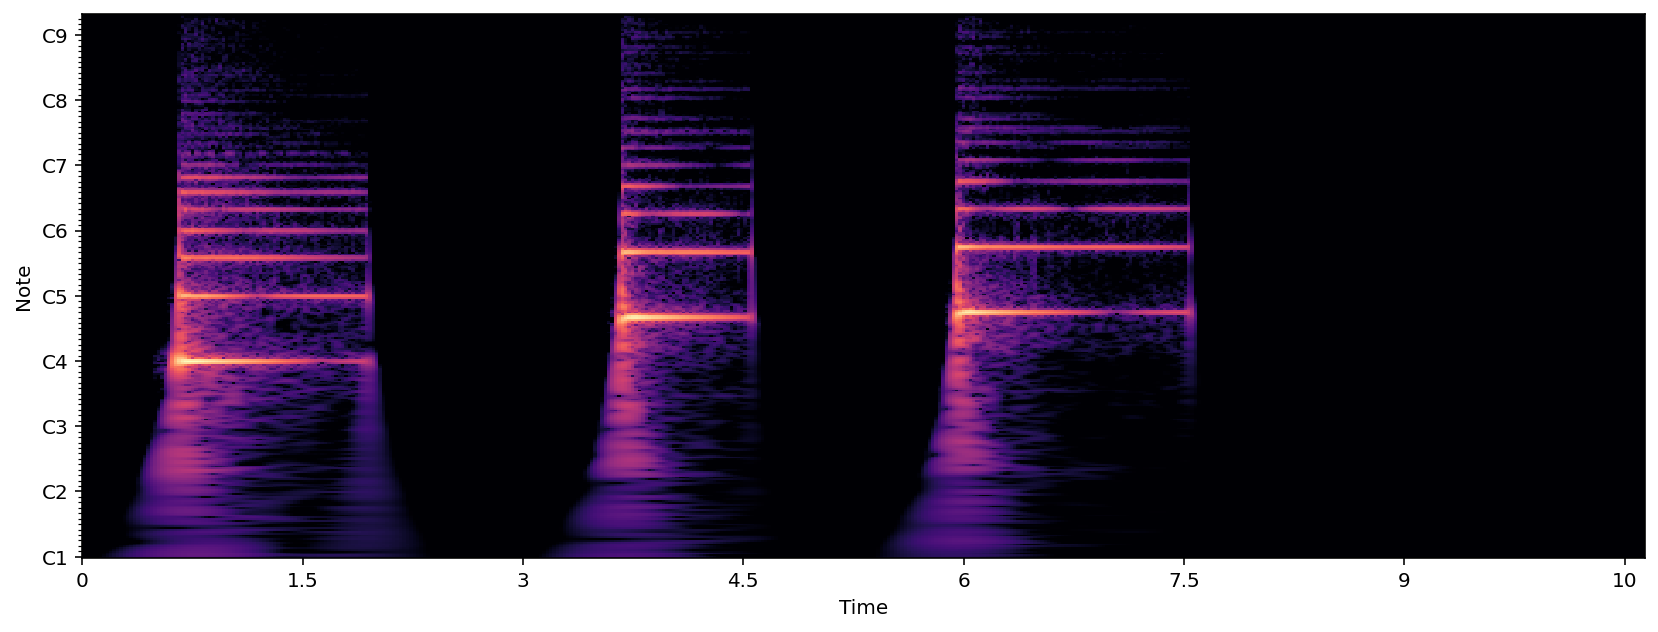

In [ ]:
#funcion para calcular la transformada

bins_per_octave = 36
cqt = librosa.cqt(x, sr=sr, n_bins=300, bins_per_octave=bins_per_octave)
log_cqt = librosa.amplitude_to_db(cqt)

librosa.display.specshow(log_cqt, sr=sr, x_axis='time', y_axis='cqt_note', 
                         bins_per_octave=binsXoctava)

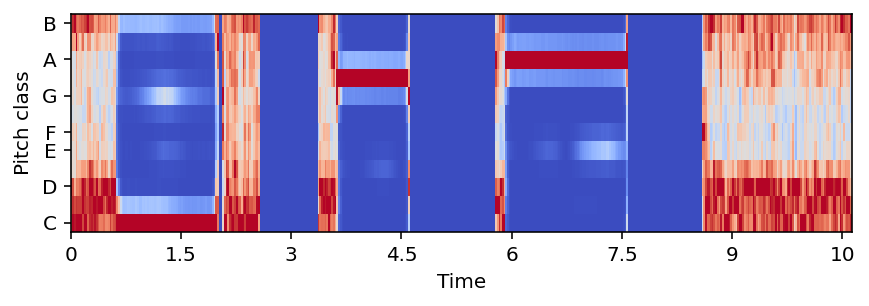

In [ ]:
#extra para visualizar mejor las frecuencias ignorando los armónicos
cromagrama = librosa.feature.chroma_stft(x, sr=sr, hop_length=hop_length)
plt.figure(figsize=(7, 2))
librosa.display.specshow(cromagrama, x_axis='time', y_axis='chroma', hop_length=hop_length, cmap='coolwarm')

# **Onset detection**

detectar eventos musicales, es decir, cuando empieza y cuando termina cada nota

In [ ]:
#importante 
# def onset_env(cqt):


In [ ]:
def calcular_onsets(log_cqt, pre_post_max=pre_post_max, backtrack=True):

  onset_env = librosa.onset.onset_strength(x, sr=sr, aggregate=np.mean, hop_length=hop_length)
  onsets = librosa.onset.onset_detect(onset_envelope=onset_env,
                                          sr=sr, units = 'samples',
                                          hop_length=512, 
                                          backtrack=False,
                                          pre_max=10,
                                          post_max=10)

  onset_limites = np.concatenate([onsets, [len(x)]])

  onset_time = librosa.samples_to_time(onset_limites, sr=sr)
  onset_segs = np.delete(onset_time, -1)
  
  return [onsets, onset_limites, onset_segs]

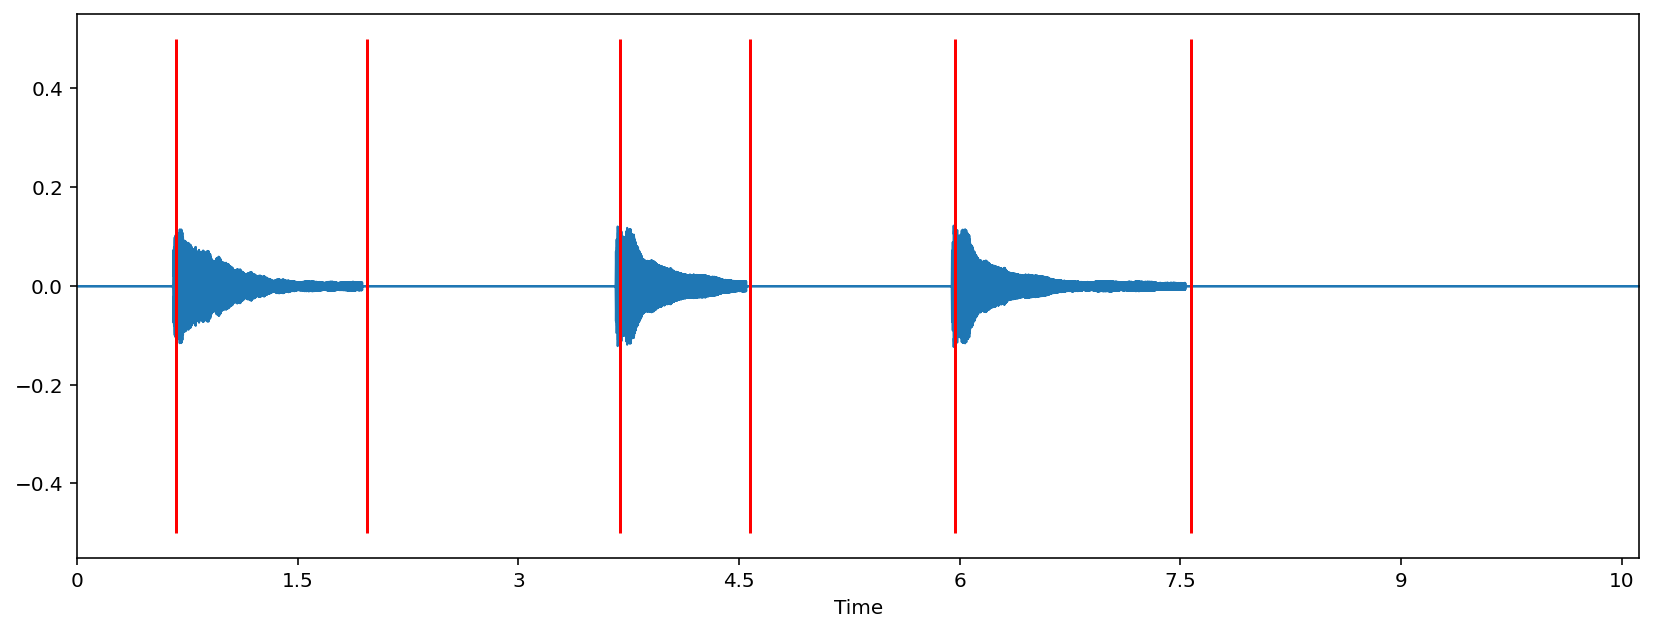

In [ ]:
#grafico de los onsets sobre la forma de onda
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr=sr)
plt.vlines(onset_segs, -0.5, 0.5, color='red', alpha=1)

# **Mas aspectos musicales**

In [ ]:
#sacar duracion de las notas
#def duracion(onset_segs):
'''PairNzum = len(onset_segs) / 2
LoopsCompleted = 0
EvaluatedIndex = 1
Duration = []
while LoopsCompleted < PairNum:
  
  Duration.append(onset_segs[EvaluatedIndex] - onset_segs[EvaluatedIndex - 1])
  EvaluatedIndex += 2
  LoopsCompleted += 1'''

  #umbral para eliminar sonidos con poca duracion

  #umbral_duracion = onset_segs.filter(umbral_duracion, onset_segs)
  #print(umbral_duracion)

  #return Duration

#duracion(onset_segs)


'PairNzum = len(onset_segs) / 2\nLoopsCompleted = 0\nEvaluatedIndex = 1\nDuration = []\nwhile LoopsCompleted < PairNum:\n  \n  Duration.append(onset_segs[EvaluatedIndex] - onset_segs[EvaluatedIndex - 1])\n  EvaluatedIndex += 2\n  LoopsCompleted += 1'

In [ ]:
#esta funcion es una que encontramos la cual estima frecuencias usando el metodo de correlacion

def estimar_frecuencias(segment, sr, frec_min=30.0, frec_max=20000.0):
        
  # Compute autocorrelation of input segment.
    correlacion = librosa.autocorrelate(segment)
    
    lim_min = sr/frec_max
    lim_max = sr/frec_min
    correlacion[:int(lim_min)] = 0
    correlacion[int(lim_max):] = 0
    
  # Find the location of the maximum autocorrelation
    i = correlacion.argmax()
    frecuencias = float(sr)/i
    return frecuencias

In [ ]:
def generar_sinusoide(frecuencias, sr, n_duration):
    n = np.arange (n_duration)
    return 0.2*np.sin(2*np.pi*frecuencias*n/float(sr)) 

## sinusoides:

In [ ]:
def generar_sinusoides_por_estimacion(x, onsets, i, sr):
    n0 = onsets[i]
    n1 = onsets[i+1]
    frecuencias = estimar_frecuencias(x[n0:n1], sr)
    return generar_sinusoide(frecuencias, sr, n1-n0)

In [ ]:
y = np.concatenate([
    generar_sinusoides_por_estimacion(x, onset_limites, i, sr)
    for i in range(len(onset_limites)-1)
])

In [ ]:
#audio de las notas en ondas senoidales
ipd.Audio(y, rate = sr)

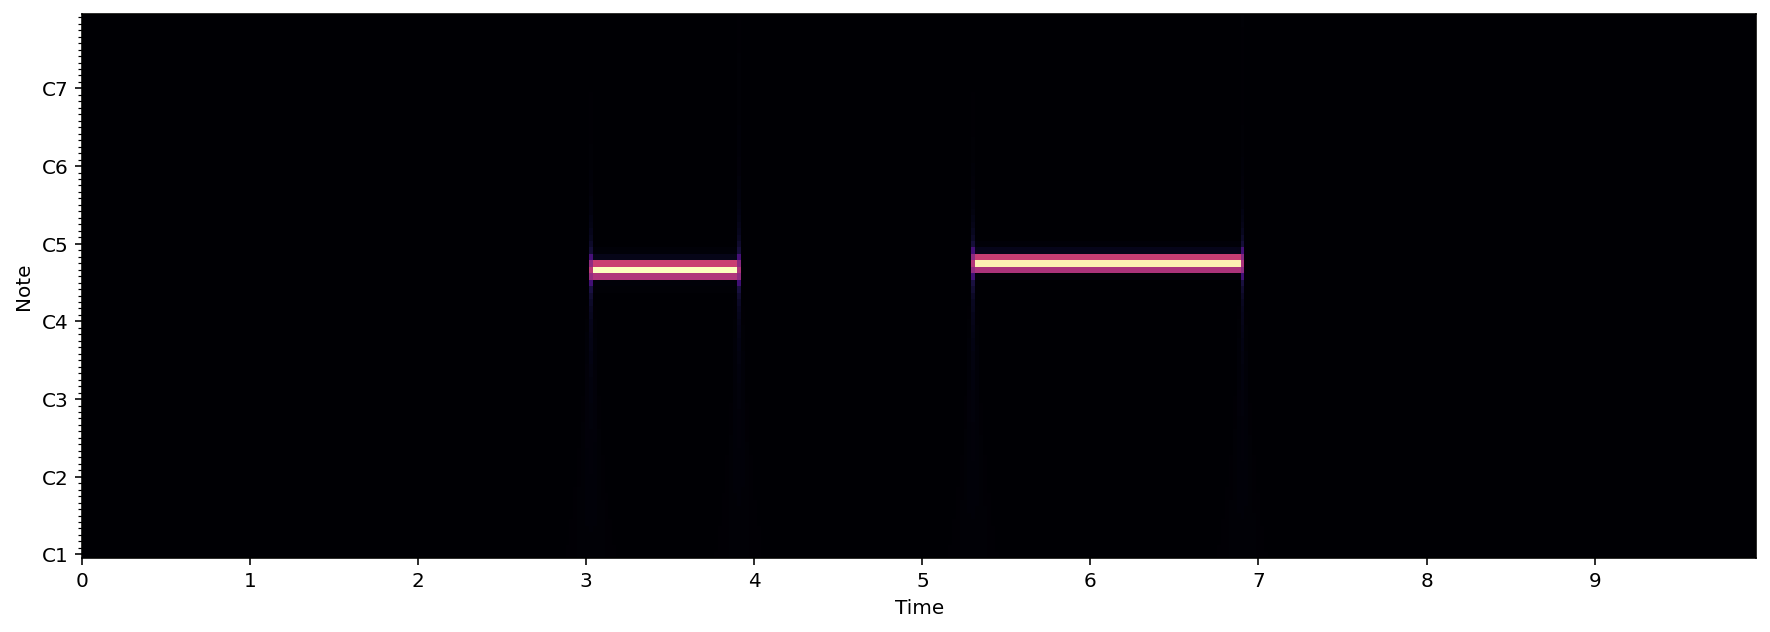

In [ ]:
CQT = librosa.cqt(y, sr=sr)

plt.figure(figsize=(15,5))
librosa.display.specshow(abs(CQT), sr=sr, x_axis='time', y_axis='cqt_note')

In [ ]:
tempo = librosa.beat.tempo(x, sr=sr)

In [ ]:
tempo, beats=librosa.beat.beat_track(y=None, sr=fs, onset_envelope=onset_env, hop_length=hop_length,
               start_bpm=120.0, tightness=100, trim=True, bpm=None,
               units='frames')

tempo=int(2*round(tempo/2))
mm = MetronomeMark(referent='quarter', number=tempo)

In [ ]:
def remap(x, in_min, in_max, out_min, out_max):
    return (x - in_min) * (out_max - out_min) / (in_max - in_min) + out_min

In [ ]:
def time_to_beat(duration, tempo):
    return (tempo*duration/60)

In [ ]:
def generar_onda_midi(f0_info, sr, n_duration, round_to_sixtenth=True):
    f0=f0_info[0]
    A=remap(f0_info[1], log_cqt.min(), log_cqt.max(), 0, 1)
    duration = librosa.frames_to_time(n_duration, sr=fs, hop_length=hop_length)
    #Generate Midi Note and music21 note
    note_duration = 0.02*np.around(duration/2/0.02) # Round to 2 decimal places for music21 compatibility
    midi_duration = time_to_beat(duration, tempo)
    midi_velocity=int(round(remap(f0_info[1], log_cqt.min(), log_cqt.max(), 0, 127)))
    if round_to_sixtenth:
        midi_duration=round(midi_duration*16)/16
    if f0==None:
        midi_note=None
        note_info=Rest(type=mm.secondsToDuration(note_duration).type)
        f0=0
    else:
        midi_note=round(librosa.hz_to_midi(f0))
        note = Note(librosa.midi_to_note(midi_note), type=mm.secondsToDuration(note_duration).type)
        note.volume.velocity = midi_velocity
        note_info = [note]
    midi_info = [midi_note, midi_duration, midi_velocity]
            
    # Generate Sinewave
    n = np.arange(librosa.frames_to_samples(n_duration, hop_length=hop_length ))
    sine_wave = A*np.sin(2*np.pi*f0*n/float(sr))
    return [sine_wave, midi_info, note_info]

In [ ]:
def estimate_pitch_and_notes(x, onset_limites, i, sr):
    n0 = onset_limites[i]
    n1 = onset_limites[i+1]
    f0_info = estimar_frecuencias(np.mean(x[:,n0:n1],axis=1)
    return generar_onda_midi(f0_info, sr, n1-n0)

In [ ]:
onsets = np.array([calcular_onsets(log_cqt, pre_post_max=pre_post_max, backtrack=True)])

music_info = np.array([
    estimate_pitch_and_notes(log_cqt, onsets[1], i, sr=fs)
    for i in range(len(onsets))
])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


IndexError: ignored

In [ ]:
synth_audio=np.concatenate(music_info[:,0])

In [ ]:
ipd.Audio(synth_audio, rate=fs)

In [ ]:
note_info = list(music_info[:,2])

## tempo y beat tracking:

# **Traduccion**

In [ ]:
#aca empieza la traduccion a MIDI

#usando music21 podemos crear notas y luego pasarlas a pentagrama o a MIDI

#funcion para recorrer arrays de ondas senoidales
'''a = [[1, 2, 3, 4], [5, 6], [7, 8, 9]]
for i in range(len(a)):
    for j in range(len(a[i])):
        print(a[i][j], end=' ')
    print()

for columns in range(len(a)):
  for item in range(len(a[columns]):
'''

# **Notas**

In [ ]:
# notas


#hay que resolver el problema del audio de las ondas senoidales

#hay que cambiar la funcion que genera ondas por una que permita que la onda deje de sonar

#